In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [3]:
# First, lets load the dataset
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.43,0.44,0.47],std=[0.20,0.20,0.20])])                          
data_train = dset.SVHN('./data/', split='train',transform=transform,download=True)
data_test = dset.SVHN('./data/', split='test', transform=transform,download=True)

0it [00:00, ?it/s]

 99%|█████████▉| 180994048/182040794 [00:16<00:00, 13116390.89it/s]
0it [00:00, ?it/s]


100%|█████████▉| 64028672/64275384 [00:08<00:00, 11847788.54it/s]

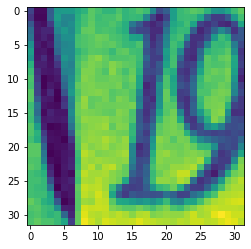

In [4]:
data_train[0][0][0].shape
plt.imshow(data_train[0][0][0])

In [5]:
data_train.data.shape

(73257, 3, 32, 32)

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


In [0]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [0]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if scheduler is not None:
            scheduler.step(val_accuracy)
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]

    return float(correct_samples) / total_samples

#loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

In [10]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

182042624it [00:29, 13116390.89it/s]                               
64282624it [00:21, 11847788.54it/s]                              

Average loss: 2.166462, Train accuracy: 0.200867, Val accuracy: 0.247014
Average loss: 1.959147, Train accuracy: 0.295311, Val accuracy: 0.355266
Average loss: 1.775154, Train accuracy: 0.386240, Val accuracy: 0.427548
Average loss: 1.703722, Train accuracy: 0.420059, Val accuracy: 0.442154
Average loss: 1.680753, Train accuracy: 0.434768, Val accuracy: 0.435738


In [11]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.933451, Train accuracy: 0.381565, Val accuracy: 0.555525
Average loss: 1.489743, Train accuracy: 0.598556, Val accuracy: 0.652652
Average loss: 1.312098, Train accuracy: 0.655155, Val accuracy: 0.672855
Average loss: 1.213978, Train accuracy: 0.683582, Val accuracy: 0.692444
Average loss: 1.155003, Train accuracy: 0.702317, Val accuracy: 0.721248


In [12]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 1.599917, Train accuracy: 0.510818, Val accuracy: 0.573340
Average loss: 1.434032, Train accuracy: 0.604290, Val accuracy: 0.586854
Average loss: 1.489840, Train accuracy: 0.603283, Val accuracy: 0.567811
Average loss: 1.510682, Train accuracy: 0.598471, Val accuracy: 0.521603
Average loss: 1.506569, Train accuracy: 0.596731, Val accuracy: 0.475189


In [0]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    subs = SubsetSampler(dataset)
    predictions = []
    ground_truth = []
    
    for i in range(len(indices)):
        x, y = subs.indices[indices[i]]
        prediction = model(x.view(1,3,32,32))
        _, target = torch.max(prediction, 1)
        predictions.append(target)
        ground_truth.append(y)
    
    return np.array(predictions), np.array(ground_truth)

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

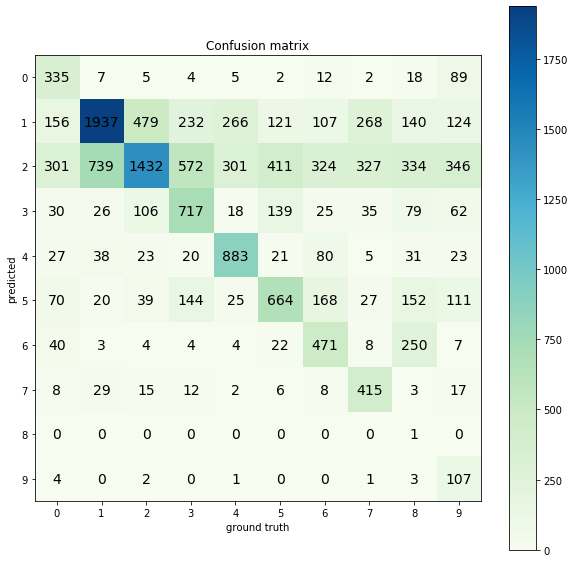

In [14]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    for i in range(10):
        for j in range(10):
            confusion_matrix[i,j] = np.sum(predictions[ground_truth==j]==i)
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

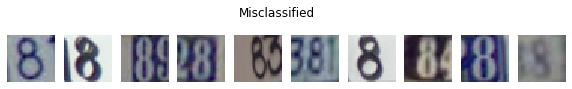

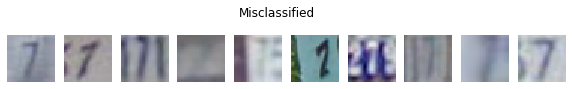

In [15]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    indices = val_indices[(gt == gt_class)&(predictions == predicted_class)]
    visualize_images(indices, data, 'Misclassified')
    

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

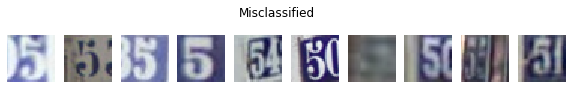

In [16]:
visualize_predicted_actual(3, 5, predictions, gt, np.array(val_indices), data_train_images)

In [23]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(inplace=True),
            nn.Linear(150, 150), 
            nn.BatchNorm1d(150),
            nn.ReLU(inplace=True),
            nn.Linear(150, 10),
         )

#optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-2)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
optimizer = optim.SGD(nn_model.parameters(), lr=0.01)
schedular = optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 20, scheduler)

Average loss: 1.472610, Train accuracy: 0.540627, Val accuracy: 0.685892
Average loss: 1.023224, Train accuracy: 0.688428, Val accuracy: 0.675381
Average loss: 0.881500, Train accuracy: 0.729140, Val accuracy: 0.743977
Average loss: 0.792588, Train accuracy: 0.755127, Val accuracy: 0.765409
Average loss: 0.736107, Train accuracy: 0.772634, Val accuracy: 0.772985
Average loss: 0.687864, Train accuracy: 0.785858, Val accuracy: 0.807385
Average loss: 0.655803, Train accuracy: 0.797034, Val accuracy: 0.794758
Average loss: 0.622247, Train accuracy: 0.806436, Val accuracy: 0.803426
Average loss: 0.601096, Train accuracy: 0.812681, Val accuracy: 0.785271
Average loss: 0.579124, Train accuracy: 0.819626, Val accuracy: 0.805952
Average loss: 0.561213, Train accuracy: 0.825291, Val accuracy: 0.786363
Average loss: 0.548091, Train accuracy: 0.828789, Val accuracy: 0.829568
Average loss: 0.531054, Train accuracy: 0.833208, Val accuracy: 0.806703
Average loss: 0.518819, Train accuracy: 0.837286, V

In [24]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8185
